# Compare Mediations

- Those that lead to peace agreements and those that don't


In [55]:
__author__      = 'Roy Gardner'

%run ./mediation_functions.py


## Load the mediation-actor data

- Load data into a biadjacency matrix with mediations in rows and actors in columns
- Matrix values are zero except where a relation between a mediation and an actor exists where the value is an non-zero integer that codes the mediation-actor edge properties.
- Apart from the matrix other data are extracted or computed.
- All data are stored in data_dict




In [56]:

data_path = './data/'
mediation_file = 'mediation.csv'
actors_file = 'actors.csv'

data_dict = load_mediation_data(mediation_file,actors_file,data_path)

print(data_dict['header'])


['year', 'mediation ID', 'negotiation ID', 'conflict locale', 'conflict sub-locale', 'locale Gleditsch ID', 'third-party', 'third-party Gleditsch ID', 'location of neogitations', 'negotiation location Gleditsch ID', 'negotiation type', 'leading actor', 'leading actor 2', 'leading actor 3', 'good offices', 'mediation', 'hosting talks', 'negotiating and drafting', 'manipulating', 'humanitarian', 'witness/party to agreement', 'other', 'agreement', 'peace agreement', 'ceasfire agreement', 'agreement name', 'notes_1', 'source_1', 'note_2', 'source_2', 'note_3', 'source_3', 'note_4', 'source_4', 'note_5', 'source_5', 'Column1', 'Column2', 'Column3', 'Column4', 'Column5', 'Column6', 'Column7', 'Column8', 'Column9', '']


## Extract sub-matrices

In [78]:
peace_mediation_ids = [k for k,v in data_dict['vertices_dict'].items() if v['type'] == 'MED' and\
                  v['data']['peace_agreement'] == 1]

non_peace_mediation_ids = [k for k,v in data_dict['vertices_dict'].items() if v['type'] == 'MED' and\
                  v['data']['peace_agreement'] != 1]

peace_mediation_indices = [data_dict['mediation_vertices'].index(v) for v in peace_mediation_ids]
peace_matrix = data_dict['matrix'][np.ix_(peace_mediation_indices,range(0,len(data_dict['actor_vertices'])))]



non_peace_mediation_indices = [data_dict['mediation_vertices'].index(v) for v in non_peace_mediation_ids]
non_peace_matrix = data_dict['matrix'][np.ix_(non_peace_mediation_indices,\
                                              range(0,len(data_dict['actor_vertices'])))]

print(peace_matrix.shape)
print(non_peace_matrix.shape)


(57, 106)
(303, 106)


## Aggregated actors

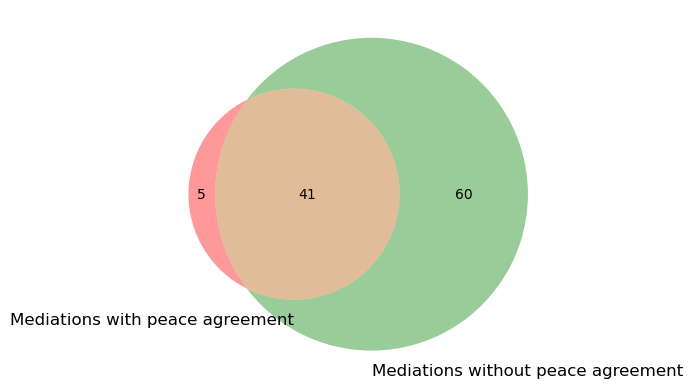


{'Philippines', 'Pakistan', 'Benin', 'Brazil', 'Tanzania'}


In [79]:
# Get columns containing non-zero value
indices = np.where(peace_matrix > 0)
peace_actor_indices = list(set(indices[1]))
peace_actor_ids = [data_dict['actor_vertices'][index] for index in peace_actor_indices]

non_indices = np.where(non_peace_matrix > 0)
non_peace_actor_indices = list(set(non_indices[1]))
non_peace_actor_ids = [data_dict['actor_vertices'][index] for index in non_peace_actor_indices]


venn2([set(peace_actor_ids),set(non_peace_actor_ids)],\
      ['Mediations with peace agreement','Mediations without peace agreement'])
plt.show()
print()

left_partition = set(peace_actor_ids).difference(set(non_peace_actor_ids))
print(left_partition)


## Lead actors

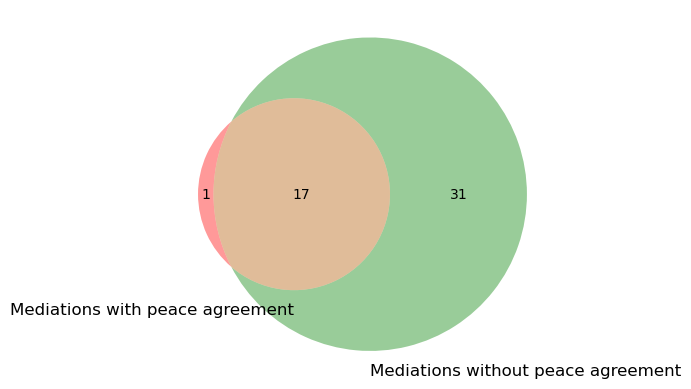


Tanzania


In [80]:
# Collect lead actors from both matrices
props_length = len(get_empty_edge_dict())

peace_indices = []
for row in peace_matrix:
    p = [int(recover_edge_dict(v,props_length)['is_lead']) for v in row]
    peace_indices.extend([i for i,v in enumerate(p) if v==1])
    
non_peace_indices = []
for row in non_peace_matrix:
    p = [int(recover_edge_dict(v,props_length)['is_lead']) for v in row]
    non_peace_indices.extend([i for i,v in enumerate(p) if v==1])

venn2([set(peace_indices),set(non_peace_indices)],\
      ['Mediations with peace agreement','Mediations without peace agreement'])
plt.show()
print()

left_partition = set(peace_indices).difference(set(non_peace_indices))
print(data_dict['actor_vertices'][list(left_partition)[0]])
  

## Lead actors

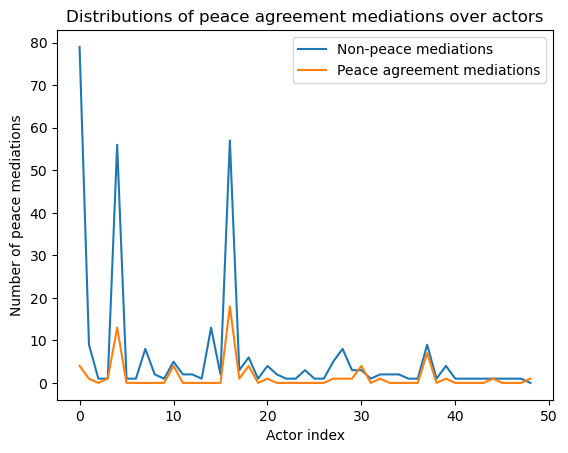


The distributions of peace agreement mediations over actors are highly correlated:
PearsonRResult(statistic=0.7406709930189902, pvalue=1.1729449904107855e-09)


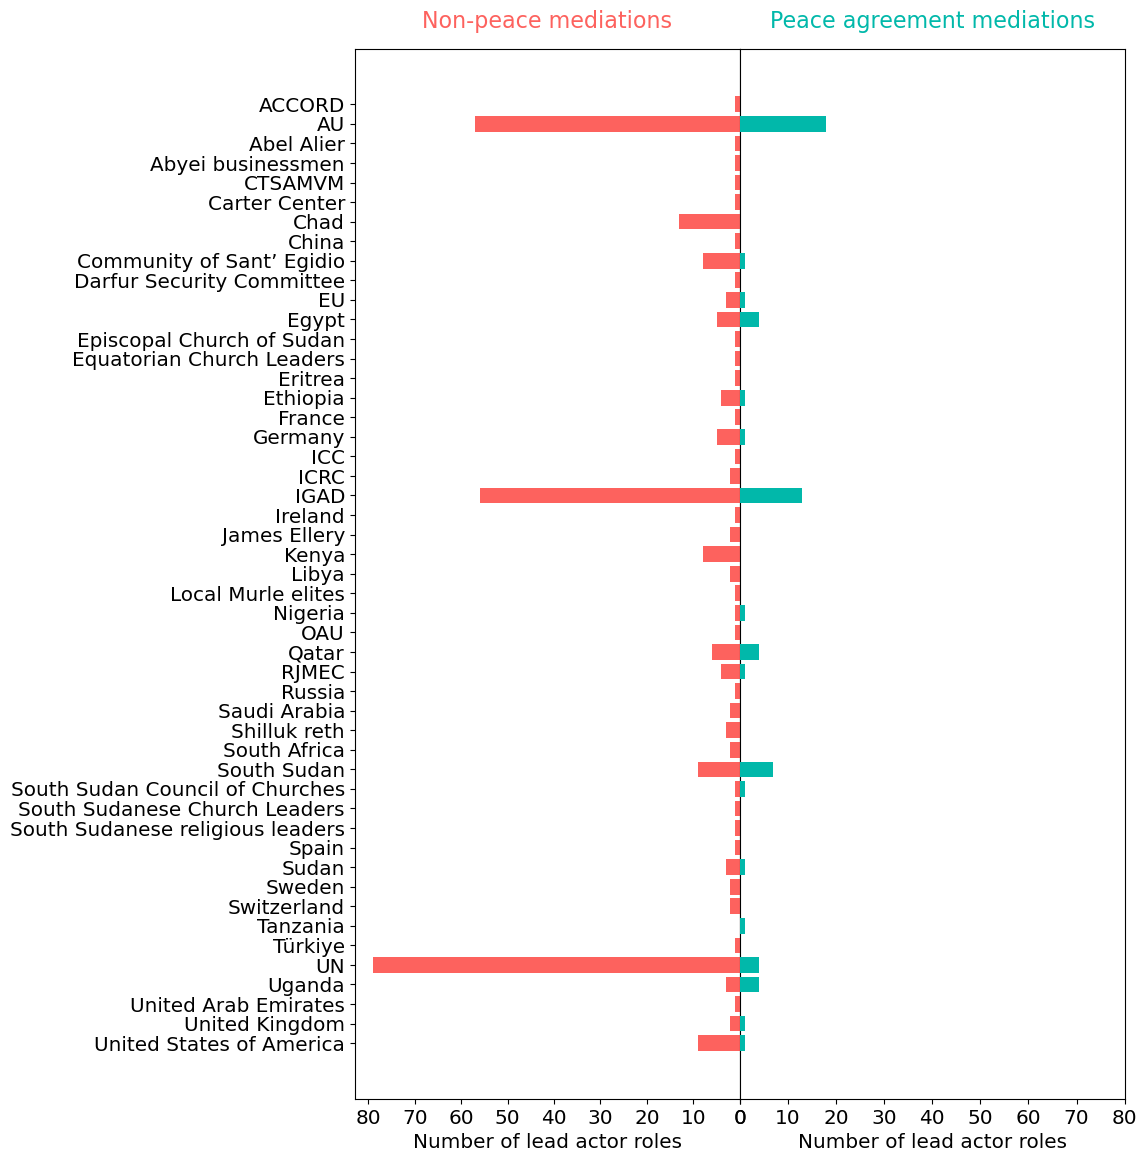

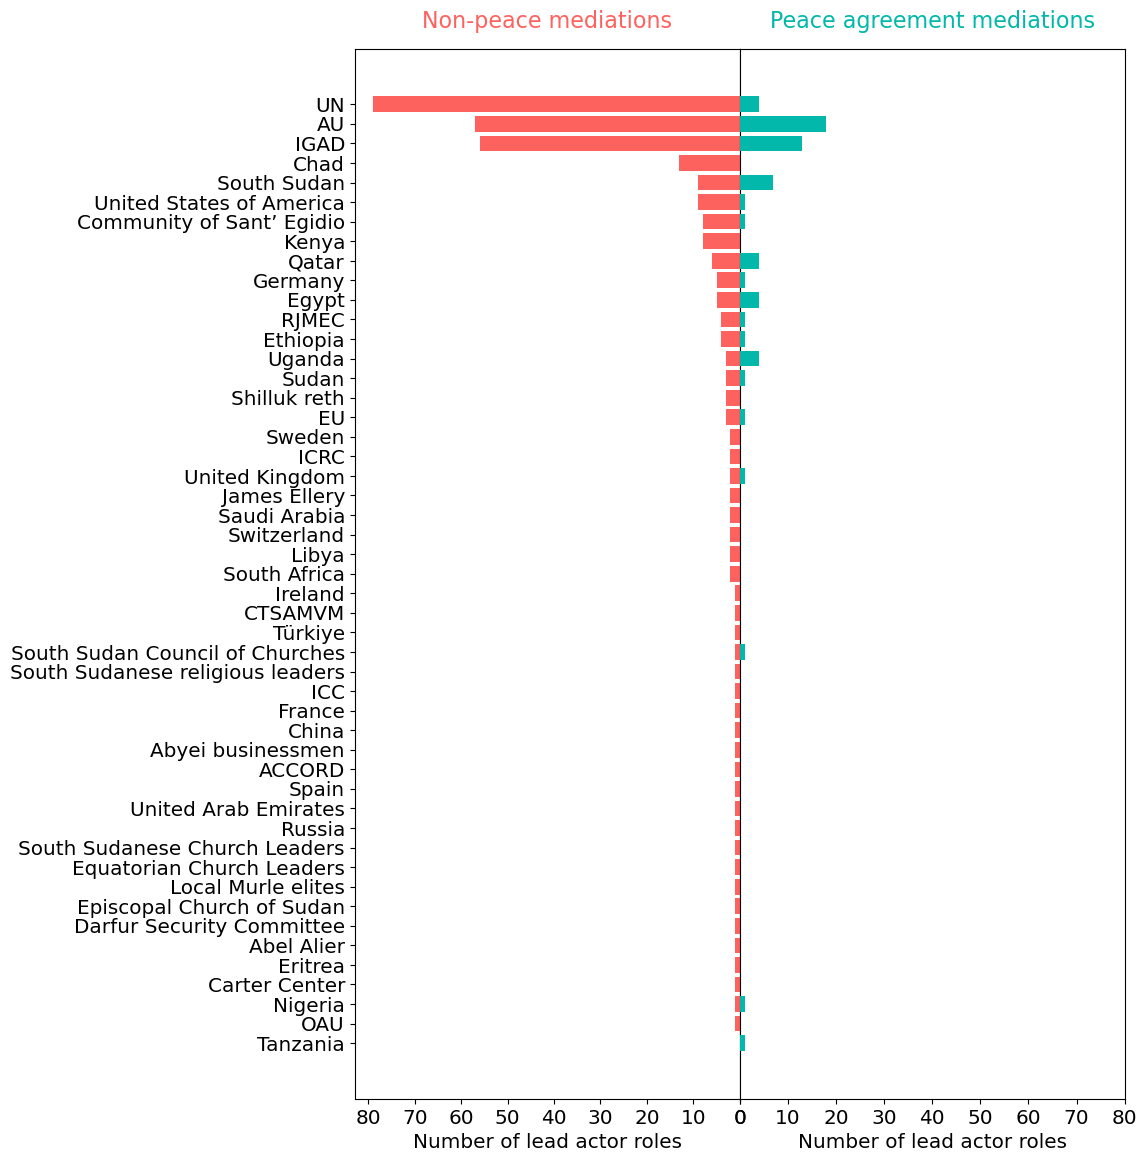

In [137]:
# Collect lead actors non-peace edges

lead_counts = {}

indices = np.where(non_peace_matrix > 0)
for i in range(0,len(indices[0])):
    mediation_index = indices[0][i]
    actor_index = indices[1][i]
    actor_id = data_dict['actor_vertices'][actor_index]
    edge_weight = non_peace_matrix[mediation_index,actor_index]
    edge_dict = recover_edge_dict(edge_weight,len(get_empty_edge_dict()))
    if int(edge_dict['is_lead']) == 1:
        if actor_id in lead_counts:
            lead_counts[actor_id][0] += 1
        else:
            lead_counts[actor_id] = [1,0]
    
# Collect lead actors from peace matrix edges
indices = np.where(peace_matrix > 0)
for i in range(0,len(indices[0])):
    mediation_index = indices[0][i]
    actor_index = indices[1][i]
    actor_id = data_dict['actor_vertices'][actor_index]
    edge_weight = peace_matrix[mediation_index,actor_index]
    edge_dict = recover_edge_dict(edge_weight,len(get_empty_edge_dict()))
    if int(edge_dict['is_lead']) == 1:
        if actor_id in lead_counts:
            lead_counts[actor_id][1] += 1
        else:
            lead_counts[actor_id] = [0,1]

plt.plot([v[0] for _,v in lead_counts.items()],label='Non-peace mediations')
plt.plot([v[1] for _,v in lead_counts.items()],label='Peace agreement mediations')
plt.ylabel('Number of peace mediations')
plt.xlabel('Actor index')
plt.legend()
plt.title('Distributions of peace agreement mediations over actors')
plt.show()

print()
print('The distributions of peace agreement mediations over actors are highly correlated:')
print(stats.pearsonr([v[0] for _,v in lead_counts.items()],[v[1] for _,v in lead_counts.items()]))

sorted_leads = sorted(lead_counts.items(),key=lambda kv:kv[0],reverse=True)
plot_birectional([(t[0],t[1][0]) for t in sorted_leads],[(t[0],t[1][1]) for t in sorted_leads],\
                 ['Non-peace mediations','Peace agreement mediations'],max_x=0,labelled=True,file='')


sorted_leads = sorted(lead_counts.items(),key=lambda kv:kv[1][0])

plot_birectional([(t[0],t[1][0]) for t in sorted_leads],[(t[0],t[1][1]) for t in sorted_leads],\
                 ['Non-peace mediations','Peace agreement mediations'],max_x=0,labelled=True,file='')


## Co-occurrence

106



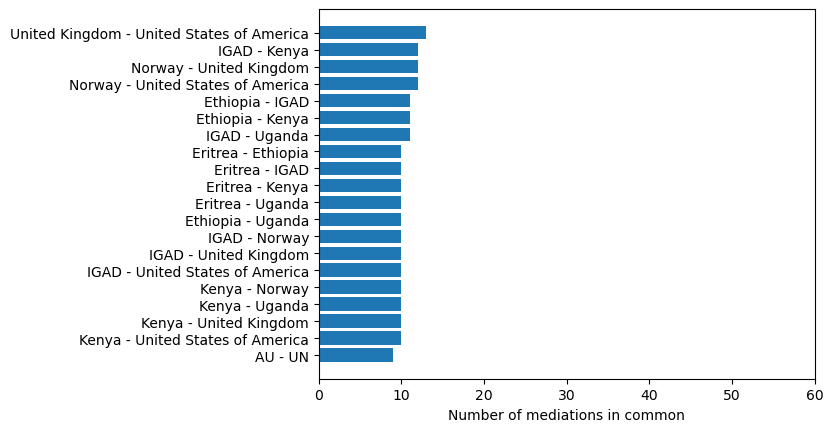

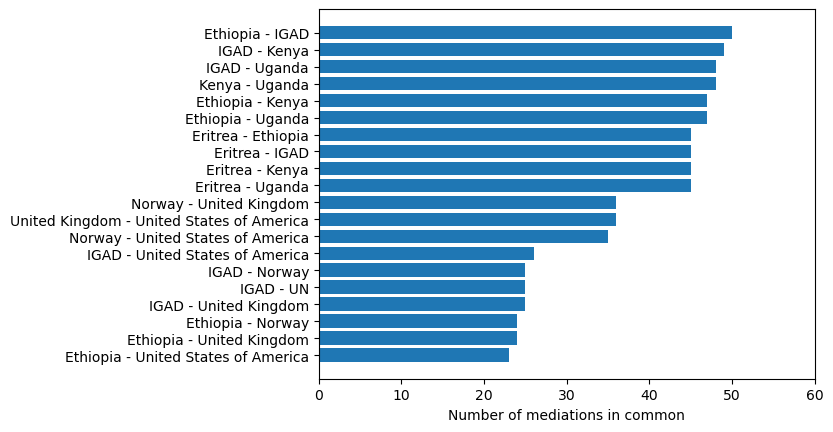

In [87]:
actor_ids = data_dict['actor_vertices']
print(len(actor_ids))

# Get the co-occurrence matrix
peace_co_matrices = get_cooccurrence_matrices(peace_matrix)
non_peace_co_matrices = get_cooccurrence_matrices(non_peace_matrix)

peace_actor_upper = np.triu(peace_co_matrices[0],k=1)
non_peace_actor_upper = np.triu(non_peace_co_matrices[0],k=1)

rc = np.nonzero(peace_actor_upper) # Row and column indices of non-zero pairs
z = list(zip(list(rc[0]),list(rc[1])))
scores = [(actor_ids[t[0]],actor_ids[t[1]],peace_actor_upper[t[0]][t[1]]) for t in z]
scores = sorted(scores,key=lambda t:t[2],reverse=True)
#print(scores)
print()

n = 20

plt.barh(range(0,n),[t[2] for t in scores[0:n]])
plt.yticks(range(0,n),[t[0] + ' - ' + t[1] for t in scores[0:n]])
plt.xticks(range(0,70,10))
plt.xlabel('Number of mediations in common')
plt.gca().invert_yaxis()
plt.show()

rc = np.nonzero(non_peace_actor_upper) # Row and column indices of non-zero pairs
z = list(zip(list(rc[0]),list(rc[1])))
scores = [(actor_ids[t[0]],actor_ids[t[1]],non_peace_actor_upper[t[0]][t[1]]) for t in z]
scores = sorted(scores,key=lambda t:t[2],reverse=True)

plt.barh(range(0,n),[t[2] for t in scores[0:n]])
plt.yticks(range(0,n),[t[0] + ' - ' + t[1] for t in scores[0:n]])
plt.xticks(range(0,70,10))
plt.xlabel('Number of mediations in common')
plt.gca().invert_yaxis()
plt.show()


### Diagonals

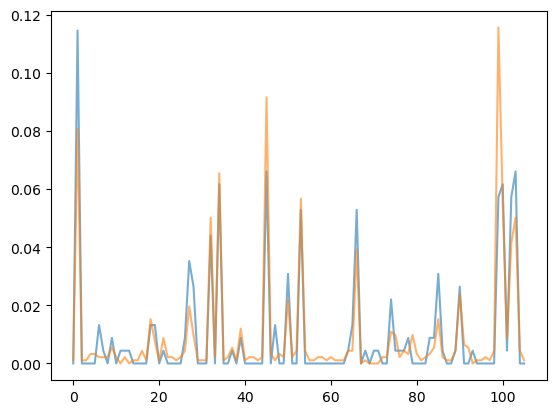

PearsonRResult(statistic=0.9009741980646956, pvalue=1.6687861392668955e-39)


In [88]:
peace_mediation_ids = [k for k,v in data_dict['vertices_dict'].items() if v['type'] == 'MED' and\
                  v['data']['peace_agreement'] == 1]

non_peace_mediation_ids = [k for k,v in data_dict['vertices_dict'].items() if v['type'] == 'MED' and\
                  v['data']['peace_agreement'] != 1]

peace_mediation_indices = [data_dict['mediation_vertices'].index(v) for v in peace_mediation_ids]
peace_matrix = data_dict['matrix'][np.ix_(peace_mediation_indices,range(0,len(data_dict['actor_vertices'])))]


non_peace_mediation_indices = [data_dict['mediation_vertices'].index(v) for v in non_peace_mediation_ids]
non_peace_matrix = data_dict['matrix'][np.ix_(non_peace_mediation_indices,\
                                              range(0,len(data_dict['actor_vertices'])))]


peace_co_matrices = get_cooccurrence_matrices(peace_matrix)
non_peace_co_matrices = get_cooccurrence_matrices(non_peace_matrix)

peace_diag = np.diag(peace_co_matrices[0])
tot = sum(peace_diag)
peace_diag = [v/tot for v in peace_diag]

non_peace_diag = np.diag(non_peace_co_matrices[0])
tot = sum(non_peace_diag)
non_peace_diag = [v/tot for v in non_peace_diag]

x = range(0,len(peace_diag))
plt.plot(x,peace_diag,alpha=0.6)
plt.plot(x,non_peace_diag,alpha=0.6)
plt.show()

print(stats.pearsonr(peace_diag,non_peace_diag))


In [89]:
from scipy.signal import find_peaks

print('Peace')
p = find_peaks(peace_diag,height=0.06)
z = list(zip(list(p[0]),list(p[1]['peak_heights'])))
z = sorted(z,key=lambda t:t[1],reverse=True)
for t in z:
    print('\t',data_dict['actor_vertices'][t[0]])
print()

print('Non-peace')
p = find_peaks(non_peace_diag,height=0.04)
z = list(zip(list(p[0]),list(p[1]['peak_heights'])))
z = sorted(z,key=lambda t:t[1],reverse=True)
for t in z:
    print('\t',data_dict['actor_vertices'][t[0]])
print()


Peace
	 AU
	 IGAD
	 United States of America
	 Ethiopia
	 Uganda

Non-peace
	 UN
	 IGAD
	 AU
	 Ethiopia
	 Kenya
	 Eritrea
	 United States of America



## Classifiers

### Single mediation roles

- Convert rows to binary-valued vectors where:
    - 1 = actor has defined mediation role
    - 0 = actor does not have a defined mediation role
        

In [279]:
prop = 'witness'

X = []
y = []

for i,row in enumerate(data_dict['matrix']):
    mediation_id = data_dict['mediation_vertices'][i]
    if data_dict['vertices_dict'][mediation_id]['data']['peace_agreement'] == 1:
        y.append(1)
    else:
        y.append(0)
    X.append([int(recover_edge_dict(v,props_length)[prop]) for v in row])
    

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=100)

knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X, y)

pos_count = len([v for v in y_test if v==1])
neg_count = len(y_test) - pos_count

pred = knn.predict(X_test)
score = knn.score(X_test,y_test)


print(score)
# True positive
tp = round(len([i for i,v in enumerate(pred) if pred[i]==1 and y_test[i]==1])/pos_count,3)
print('TP',tp)
# False positive
fp = round(len([i for i,v in enumerate(pred) if pred[i]==1 and y_test[i]==0])/neg_count,3)
print('FP',fp)
# True negative
tn = round(len([i for i,v in enumerate(pred) if pred[i]==0 and y_test[i]==0])/neg_count,3)
print('TN',tn)    
# False negative
fn = round(len([i for i,v in enumerate(pred) if pred[i]==0 and y_test[i]==1])/pos_count,3)
print('FN',fn)
print()


0.9
TP 0.412
FP 0.0
TN 1.0
FN 0.588



### Pairs of mediation roles

- Convert rows to binary-valued vectors where:
    - 1 = actor has defined mediation roles
    - 0 = actor does not have defined mediation roles


In [282]:
prop_pair = ['mediation','witness']

X = []
y = []

for i,row in enumerate(data_dict['matrix']):
    mediation_id = data_dict['mediation_vertices'][i]
    if data_dict['vertices_dict'][mediation_id]['data']['peace_agreement'] == 1:
        y.append(1)
    else:
        y.append(0)
    prop_vector_1 = [int(recover_edge_dict(v,props_length)[prop_pair[0]]) for v in row]
    prop_vector_2 = [int(recover_edge_dict(v,props_length)[prop_pair[1]]) for v in row]
    X.append(np.bitwise_and(prop_vector_1,prop_vector_2))
    

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=100)

knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X, y)

pos_count = len([v for v in y_test if v==1])
neg_count = len(y_test) - pos_count

pred = knn.predict(X_test)
score = knn.score(X_test,y_test)


print(score)
# True positive
tp = round(len([i for i,v in enumerate(pred) if pred[i]==1 and y_test[i]==1])/pos_count,3)
print('TP',tp)
# False positive
fp = round(len([i for i,v in enumerate(pred) if pred[i]==1 and y_test[i]==0])/neg_count,3)
print('FP',fp)
# True negative
tn = round(len([i for i,v in enumerate(pred) if pred[i]==0 and y_test[i]==0])/neg_count,3)
print('TN',tn)    
# False negative
fn = round(len([i for i,v in enumerate(pred) if pred[i]==0 and y_test[i]==1])/pos_count,3)
print('FN',fn)
print()



0.94
TP 0.538
FP 0.0
TN 1.0
FN 0.462

